In [24]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score # Otra métrica para evaluar clusters
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency # Para prueba Chi-cuadrado

# Clusterización usando K-Means
De acuerdo a la conclusión anterior, realizaremos un análisis con el módelo k-means, el cual nos traerá por medio de aprendizaje no-supervisado grupos de CVs con varios factores en común, desde los cuales podremos obtener una conclusión inicial para el objetivo de nuestro proyecto.

Datos cargados desde '../Bases/base_cvs/datos_para_clusterisar.csv'. Dimensiones: (614, 50)
Columnas disponibles: ['Numero de Paginas', 'Densidad Informacion (%)', 'Fechas Detectadas (Count)', 'Tamaño cuerpo probable', 'Variedad de fuentes', 'Variedad de tamaños', 'Uso de negritas (estimado %)', 'Uso de cursivas (estimado %)', 'Porcentaje Lenguaje Técnico', 'LinkedIn', 'GitHub', 'Website/Otro', 'Cantidad de imágenes', 'Tiene Elementos Graficos', 'Lineas_education', 'Lineas_work_experience', 'Lineas_skills', 'Lineas_certifications', 'Lineas_achievements', 'Lineas_professional_profile', 'Lineas_languages', 'Lineas_projects', 'Lineas_publications', 'Lineas_training_courses', 'Lineas_volunteer_work', 'Seccion_languages', 'Seccion_publications', 'Seccion_training_courses', 'texto_extraido_len', 'Promedio tamaño fuente', 'Formato Texto (Lineas)_Párrafos', 'Formato Texto (Lineas)_Viñetas', 'Orden Temporal_Orden Temporal Detectado', 'Formato Fecha Más Común_MM-YYYY', 'Formato Fecha Más Común_M

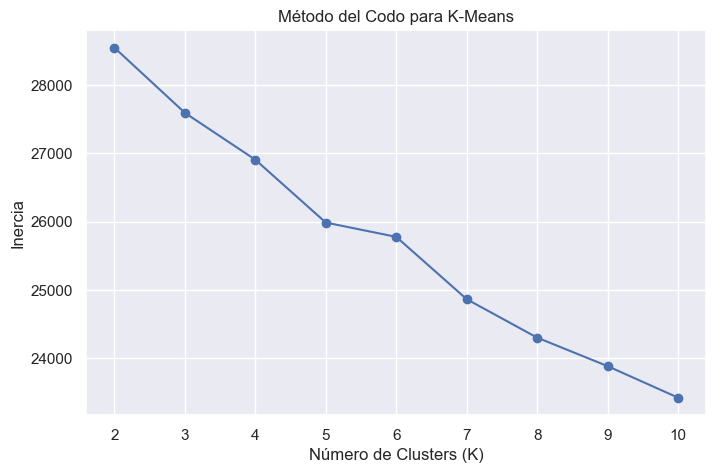

Observa el gráfico: elige el valor de K donde la línea 'forma un codo' (la disminución de la inercia se vuelve mucho más lenta).

>>> Aplicando K-Means con K=5 (¡Asegúrate de ajustar 'chosen_k' según el gráfico!) <<<

Etiquetas de cluster (0 a 4) añadidas al DataFrame (columna 'Cluster').

--- Análisis Descriptivo de los Clusters ---

Distribución de CVs por cluster:
Cluster
0     97
1    151
2    124
3    241
4      1
Name: count, dtype: int64

Medias de features por cluster:
Cluster                                                 0            1  \
Numero de Paginas                                1.948454     2.052980   
Densidad Informacion (%)                         6.892784     6.675695   
Fechas Detectadas (Count)                        1.164948     1.543046   
Tamaño cuerpo probable                           9.567010     9.536424   
Variedad de fuentes                              4.463918     5.291391   
Variedad de tamaños                              5.175258     7.523179   


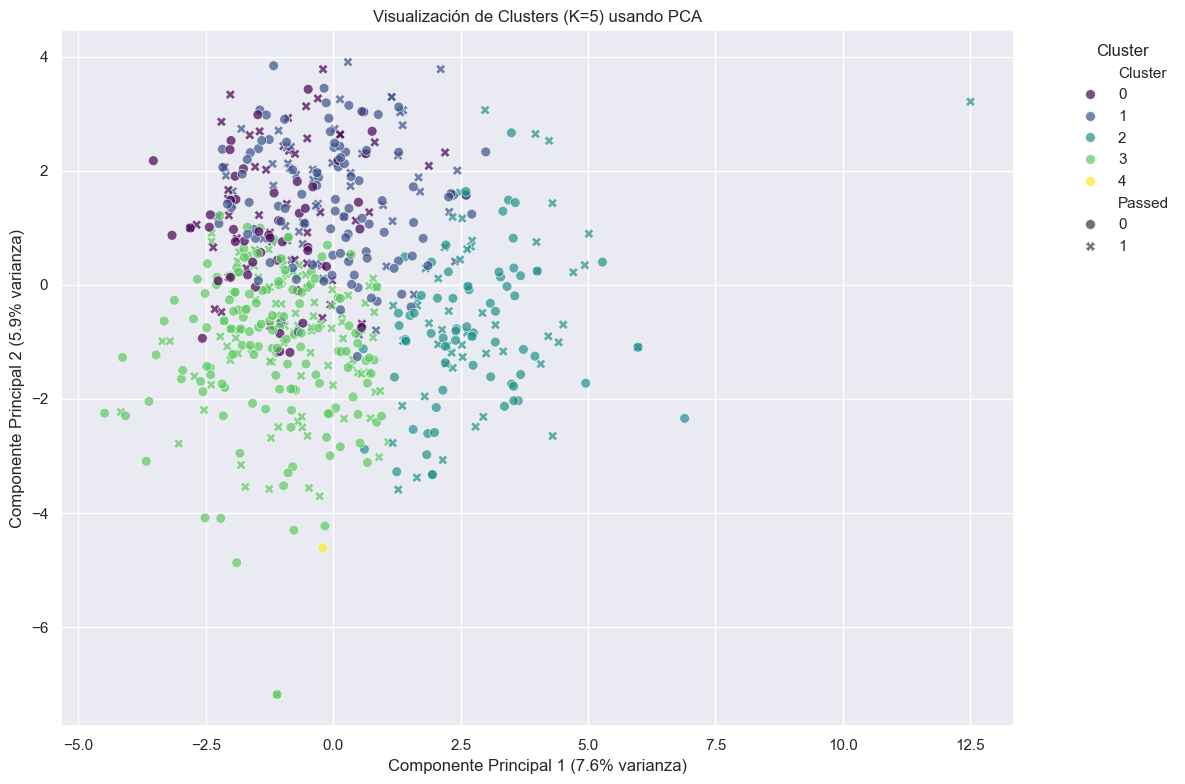

In [28]:
# --- 1. Cargar los Datos ---
# Asegúrate de que la ruta y el separador sean correctos para tu archivo
csv_path_cluster = '../Bases/base_cvs/datos_para_clusterisar.csv'
try:
    # Intentar detectar separador o especificarlo (ej. sep=',')
    df_cluster_orig = pd.read_csv(csv_path_cluster)
    print(f"Datos cargados desde '{csv_path_cluster}'. Dimensiones: {df_cluster_orig.shape}")
    print("Columnas disponibles:", df_cluster_orig.columns.tolist())
except FileNotFoundError:
    print(f"Error: No se encontró el archivo '{csv_path_cluster}'.")
    df_cluster_orig = None
except Exception as e:
    print(f"Error cargando datos: {e}")
    df_cluster_orig = None

# --- Solo proceder si los datos se cargaron ---
if df_cluster_orig is not None:

    # --- 2. Preparar Datos para Clustering ---
    target_column = 'Passed'

    # Verificar si 'Passed' existe y separarla (la usaremos después)
    if target_column in df_cluster_orig.columns:
        y_labels = df_cluster_orig[target_column].copy()
        X_cluster = df_cluster_orig.drop(columns=[target_column])
        print(f"\nSeparando features (X) y target '{target_column}'.")
    else:
        print(f"\nAdvertencia: Columna '{target_column}' no encontrada. Se usarán todas las columnas para clustering.")
        y_labels = None
        X_cluster = df_cluster_orig.copy()

    # Asegurar que todas las features son numéricas
    original_cols = X_cluster.shape[1]
    X_cluster = X_cluster.select_dtypes(include=np.number)
    if X_cluster.shape[1] < original_cols:
         print(f"Advertencia: Se eliminaron {original_cols - X_cluster.shape[1]} columnas no numéricas.")

    # Verificar y manejar NaNs (Imputar si es necesario)
    if X_cluster.isnull().sum().sum() > 0:
        print(f"\nAdvertencia: {X_cluster.isnull().sum().sum()} NaNs encontrados. Imputando con la media...")
        from sklearn.impute import SimpleImputer
        imputer_cluster = SimpleImputer(strategy='mean')
        X_cluster_imputed = imputer_cluster.fit_transform(X_cluster)
        X_cluster = pd.DataFrame(X_cluster_imputed, columns=X_cluster.columns)
        print("Imputación completada.")
    else:
        print("\nNo se encontraron NaNs en las features.")

    # Guardar nombres de features
    feature_names_cluster = X_cluster.columns.tolist()
    print(f"Número de features para clustering: {len(feature_names_cluster)}")

    # --- 3. Escalar TODAS las Features ---
    print("\nEscalando todas las features para K-Means...")
    scaler_cluster = StandardScaler()
    X_scaled_cluster = scaler_cluster.fit_transform(X_cluster)
    print("Escalado completado.")

    # --- 4. Determinar Número Óptimo de Clusters (K) - Método del Codo ---
    print("\nCalculando inercia para K de 2 a 10 (Método del Codo)...")
    inertia = []
    k_range = range(2, 11) # Puedes ajustar este rango si quieres probar más clusters

    for k in k_range:
        kmeans_test = KMeans(n_clusters=k, random_state=42, n_init=10) # n_init='auto' en sklearn >= 1.3
        kmeans_test.fit(X_scaled_cluster)
        inertia.append(kmeans_test.inertia_) # Inertia: Suma de cuadrados intra-cluster

    # Graficar el codo
    try:
        plt.figure(figsize=(8, 5))
        plt.plot(k_range, inertia, marker='o')
        plt.xlabel('Número de Clusters (K)')
        plt.ylabel('Inercia')
        plt.title('Método del Codo para K-Means')
        plt.xticks(k_range)
        plt.grid(True)
        plt.show()
        print("Observa el gráfico: elige el valor de K donde la línea 'forma un codo' (la disminución de la inercia se vuelve mucho más lenta).")
    except Exception as e_elbow_plot:
         print(f"No se pudo generar el gráfico del codo: {e_elbow_plot}")

    # --- 5. Aplicar K-Means con K elegido ---
    # *** AJUSTA EL VALOR DE 'chosen_k' BASADO EN EL GRÁFICO DEL CODO ***
    chosen_k = 5  # Ejemplo: Elegir 4 clusters. ¡CAMBIA ESTO!
    print(f"\n>>> Aplicando K-Means con K={chosen_k} (¡Asegúrate de ajustar 'chosen_k' según el gráfico!) <<<")

    kmeans_final = KMeans(n_clusters=chosen_k, random_state=42, n_init=10)
    cluster_labels = kmeans_final.fit_predict(X_scaled_cluster)

    # Añadir etiquetas de cluster al DataFrame ORIGINAL (el que tiene 'Passed' si existía)
    df_clustered = df_cluster_orig.copy() # Usar el original cargado
    df_clustered['Cluster'] = cluster_labels
    print(f"\nEtiquetas de cluster (0 a {chosen_k-1}) añadidas al DataFrame (columna 'Cluster').")

    # --- 6. Análisis Básico de los Clusters ---
    print("\n--- Análisis Descriptivo de los Clusters ---")

    # Tamaño de cada cluster
    print("\nDistribución de CVs por cluster:")
    print(df_clustered['Cluster'].value_counts().sort_index())

    # Características promedio por cluster (usando las features seleccionadas antes del escalado)
    print("\nMedias de features por cluster:")
    # Usar 'feature_names_cluster' para asegurar que agrupamos por las columnas correctas
    try:
        cluster_analysis = df_clustered.groupby('Cluster')[feature_names_cluster].mean().transpose()
        pd.set_option('display.max_rows', None) # Mostrar todas las features
        print(cluster_analysis)
        pd.reset_option('display.max_rows')
        print("\n(Interpreta esto buscando diferencias grandes en las medias entre clusters)")
    except Exception as e_group:
        print(f"Error al calcular medias por cluster: {e_group}")


    # Relación con 'Passed' (si la columna existe)
    if y_labels is not None:
        print("\n--- Relación Exploratoria entre Clusters y 'Passed' ---")
        # Tabla de contingencia
        contingency_table = pd.crosstab(df_clustered['Cluster'], y_labels)
        print("\nTabla de Contingencia (Cluster vs Passed):")
        print(contingency_table)

        # Porcentaje de 'Passed' en cada cluster
        passed_perc_by_cluster = df_clustered.groupby('Cluster')['Passed'].mean() * 100
        print("\nPorcentaje de 'Passed'=1 en cada cluster (%):")
        print(passed_perc_by_cluster.round(2))

        # Prueba Chi-cuadrado
        try:
            chi2, p, dof, expected = chi2_contingency(contingency_table)
            print(f"\nPrueba Chi-cuadrado (Cluster vs Passed): p-value = {p:.4f}")
            if p < 0.05:
                print("--> Asociación significativa encontrada: La proporción de 'Passed' varía entre clusters.")
            else:
                print("--> No hay asociación significativa: La proporción de 'Passed' es similar entre clusters.")
        except ValueError:
            print("\nAdvertencia: No se pudo realizar Chi-cuadrado (posiblemente datos insuficientes).")
    else:
         print("\nColumna 'Passed' no disponible para análisis cruzado con clusters.")


    # --- 7. (Opcional) Visualización PCA ---
    print("\nGenerando visualización 2D de clusters usando PCA...")
    try:
        pca = PCA(n_components=2, random_state=42)
        # Usamos los datos escalados para PCA también
        X_pca = pca.fit_transform(X_scaled_cluster)
        print(f"Varianza explicada por los 2 componentes PCA: {pca.explained_variance_ratio_.sum():.2%}")

        # Crear DataFrame para graficar
        df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
        df_pca['Cluster'] = cluster_labels
        if y_labels is not None: # Añadir 'Passed' si existe para colorear diferente
             df_pca['Passed'] = y_labels

        plt.figure(figsize=(12, 8))
        sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='Cluster',
                        palette='viridis', s=50, alpha=0.7,
                        style='Passed' if y_labels is not None else None) # Diferente marcador si 'Passed' existe
        plt.title(f'Visualización de Clusters (K={chosen_k}) usando PCA')
        plt.xlabel(f'Componente Principal 1 ({pca.explained_variance_ratio_[0]:.1%} varianza)')
        plt.ylabel(f'Componente Principal 2 ({pca.explained_variance_ratio_[1]:.1%} varianza)')
        plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    except Exception as e_pca_plot:
        print(f"No se pudo generar gráfico PCA: {e_pca_plot}")


El primer proceso de clustering, con 49 variables, no nos trae resultados significativos, con una relación mínima frente a la pertenencia al cluster y la variable passed.

###  K-Means: Segunda base de datos

Clusterización solo con los datos con los que originalmente modelados y dijimos representaban el general de las CVS

Datos cargados desde '../Bases/base_cvs/datos_para_modelar_cv.csv'. Dimensiones: (614, 34)
Columnas disponibles: ['Passed', 'secciones_completas', 'texto_extraido_len', 'Porcentaje Lenguaje Técnico', 'Uso de negritas (estimado %)', 'Ratio_Lineas_Experiencia_len', 'Promedio tamaño fuente', 'Densidad Informacion (%)', 'Lineas_training_courses', 'Numero de Paginas', 'Variedad de tamaños', 'Variedad de fuentes', 'Uso de cursivas (estimado %)', 'Cantidad de imágenes', 'Fechas Detectadas (Count)', 'Website/Otro', 'Seccion_training_courses', 'Uso de colores (texto)_Sí', 'Orden Temporal_Orden Temporal Detectado', 'Legibilidad general_Buena', 'Consistencia tamaños fuente_Consistente', 'Consistencia márgenes (aprox)_Consistente', 'Deteccion Foto Perfil_Posible Foto Detectada', 'Formato Texto (Lineas)_Párrafos', 'Formato Texto (Lineas)_Viñetas', 'Fuente principal_Tahoma', 'Fuente principal_Otra', 'Formato Fecha Más Común_MM/YYYY', 'Formato Fecha Más Común_YYYY', 'Tiene Elementos Graficos', 'Linke

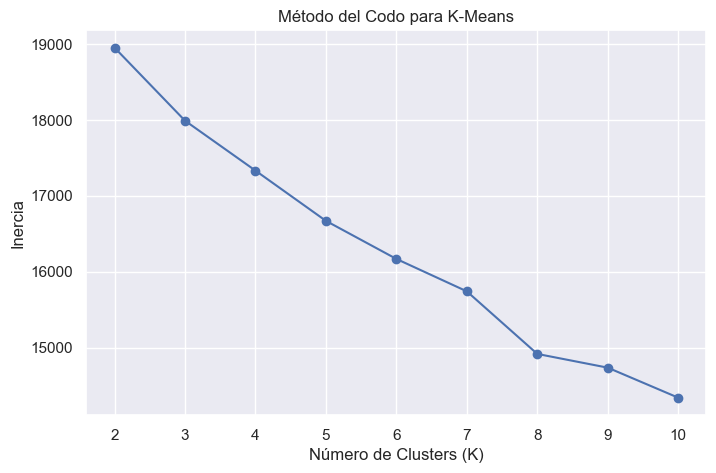

Observa el gráfico: elige el valor de K donde la línea 'forma un codo' (la disminución de la inercia se vuelve mucho más lenta).

>>> Aplicando K-Means con K=3 (¡Asegúrate de ajustar 'chosen_k' según el gráfico!) <<<

Etiquetas de cluster (0 a 2) añadidas al DataFrame (columna 'Cluster').

--- Análisis Descriptivo de los Clusters ---

Distribución de CVs por cluster:
Cluster
0    205
1    117
2    292
Name: count, dtype: int64

Medias de features por cluster:
Cluster                                                 0            1  \
secciones_completas                              8.424390     8.837607   
texto_extraido_len                            4261.253659  8537.119658   
Porcentaje Lenguaje Técnico                      7.506829     5.833590   
Uso de negritas (estimado %)                    20.008293    19.607692   
Ratio_Lineas_Experiencia_len                     0.001788     0.001749   
Promedio tamaño fuente                          13.435931    12.595233   
Densidad Informaci

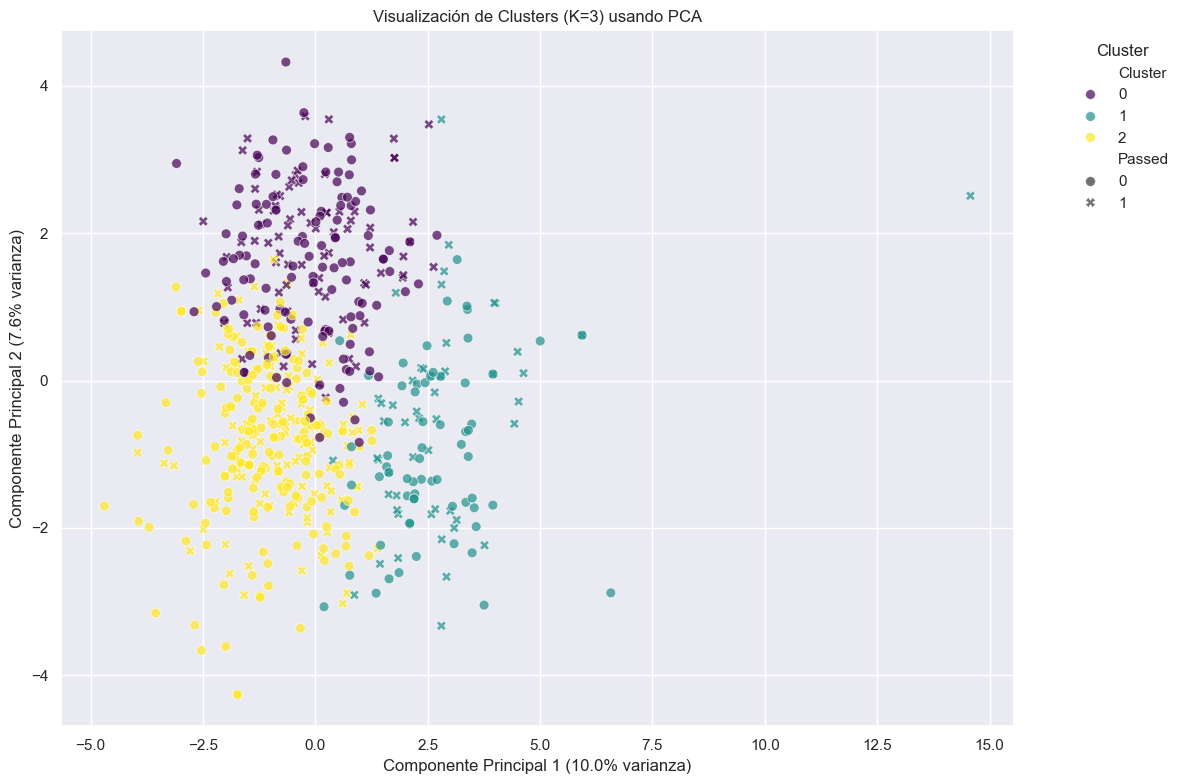

In [30]:
# --- 1. Cargar los Datos ---
# Asegúrate de que la ruta y el separador sean correctos para tu archivo
csv_path_cluster = '../Bases/base_cvs/datos_para_modelar_cv.csv'
try:
    # Intentar detectar separador o especificarlo (ej. sep=',')
    df_cluster_orig = pd.read_csv(csv_path_cluster)
    print(f"Datos cargados desde '{csv_path_cluster}'. Dimensiones: {df_cluster_orig.shape}")
    print("Columnas disponibles:", df_cluster_orig.columns.tolist())
except FileNotFoundError:
    print(f"Error: No se encontró el archivo '{csv_path_cluster}'.")
    df_cluster_orig = None
except Exception as e:
    print(f"Error cargando datos: {e}")
    df_cluster_orig = None

# --- Solo proceder si los datos se cargaron ---
if df_cluster_orig is not None:

    # --- 2. Preparar Datos para Clustering ---
    target_column = 'Passed'

    # Verificar si 'Passed' existe y separarla (la usaremos después)
    if target_column in df_cluster_orig.columns:
        y_labels = df_cluster_orig[target_column].copy()
        X_cluster = df_cluster_orig.drop(columns=[target_column])
        print(f"\nSeparando features (X) y target '{target_column}'.")
    else:
        print(f"\nAdvertencia: Columna '{target_column}' no encontrada. Se usarán todas las columnas para clustering.")
        y_labels = None
        X_cluster = df_cluster_orig.copy()

    # Asegurar que todas las features son numéricas
    original_cols = X_cluster.shape[1]
    X_cluster = X_cluster.select_dtypes(include=np.number)
    if X_cluster.shape[1] < original_cols:
         print(f"Advertencia: Se eliminaron {original_cols - X_cluster.shape[1]} columnas no numéricas.")

    # Verificar y manejar NaNs (Imputar si es necesario)
    if X_cluster.isnull().sum().sum() > 0:
        print(f"\nAdvertencia: {X_cluster.isnull().sum().sum()} NaNs encontrados. Imputando con la media...")
        from sklearn.impute import SimpleImputer
        imputer_cluster = SimpleImputer(strategy='mean')
        X_cluster_imputed = imputer_cluster.fit_transform(X_cluster)
        X_cluster = pd.DataFrame(X_cluster_imputed, columns=X_cluster.columns)
        print("Imputación completada.")
    else:
        print("\nNo se encontraron NaNs en las features.")

    # Guardar nombres de features
    feature_names_cluster = X_cluster.columns.tolist()
    print(f"Número de features para clustering: {len(feature_names_cluster)}")

    # --- 3. Escalar TODAS las Features ---
    print("\nEscalando todas las features para K-Means...")
    scaler_cluster = StandardScaler()
    X_scaled_cluster = scaler_cluster.fit_transform(X_cluster)
    print("Escalado completado.")

    # --- 4. Determinar Número Óptimo de Clusters (K) - Método del Codo ---
    print("\nCalculando inercia para K de 2 a 10 (Método del Codo)...")
    inertia = []
    k_range = range(2, 11) # Puedes ajustar este rango si quieres probar más clusters

    for k in k_range:
        kmeans_test = KMeans(n_clusters=k, random_state=42, n_init=10) # n_init='auto' en sklearn >= 1.3
        kmeans_test.fit(X_scaled_cluster)
        inertia.append(kmeans_test.inertia_) # Inertia: Suma de cuadrados intra-cluster

    # Graficar el codo
    try:
        plt.figure(figsize=(8, 5))
        plt.plot(k_range, inertia, marker='o')
        plt.xlabel('Número de Clusters (K)')
        plt.ylabel('Inercia')
        plt.title('Método del Codo para K-Means')
        plt.xticks(k_range)
        plt.grid(True)
        plt.show()
        print("Observa el gráfico: elige el valor de K donde la línea 'forma un codo' (la disminución de la inercia se vuelve mucho más lenta).")
    except Exception as e_elbow_plot:
         print(f"No se pudo generar el gráfico del codo: {e_elbow_plot}")

    # --- 5. Aplicar K-Means con K elegido ---
    # *** AJUSTA EL VALOR DE 'chosen_k' BASADO EN EL GRÁFICO DEL CODO ***
    chosen_k = 3  # Ejemplo: Elegir 4 clusters. ¡CAMBIA ESTO!
    print(f"\n>>> Aplicando K-Means con K={chosen_k} (¡Asegúrate de ajustar 'chosen_k' según el gráfico!) <<<")

    kmeans_final = KMeans(n_clusters=chosen_k, random_state=42, n_init=10)
    cluster_labels = kmeans_final.fit_predict(X_scaled_cluster)

    # Añadir etiquetas de cluster al DataFrame ORIGINAL (el que tiene 'Passed' si existía)
    df_clustered = df_cluster_orig.copy() # Usar el original cargado
    df_clustered['Cluster'] = cluster_labels
    print(f"\nEtiquetas de cluster (0 a {chosen_k-1}) añadidas al DataFrame (columna 'Cluster').")

    # --- 6. Análisis Básico de los Clusters ---
    print("\n--- Análisis Descriptivo de los Clusters ---")

    # Tamaño de cada cluster
    print("\nDistribución de CVs por cluster:")
    print(df_clustered['Cluster'].value_counts().sort_index())

    # Características promedio por cluster (usando las features seleccionadas antes del escalado)
    print("\nMedias de features por cluster:")
    # Usar 'feature_names_cluster' para asegurar que agrupamos por las columnas correctas
    try:
        cluster_analysis = df_clustered.groupby('Cluster')[feature_names_cluster].mean().transpose()
        pd.set_option('display.max_rows', None) # Mostrar todas las features
        print(cluster_analysis)
        pd.reset_option('display.max_rows')
        print("\n(Interpreta esto buscando diferencias grandes en las medias entre clusters)")
    except Exception as e_group:
        print(f"Error al calcular medias por cluster: {e_group}")


    # Relación con 'Passed' (si la columna existe)
    if y_labels is not None:
        print("\n--- Relación Exploratoria entre Clusters y 'Passed' ---")
        # Tabla de contingencia
        contingency_table = pd.crosstab(df_clustered['Cluster'], y_labels)
        print("\nTabla de Contingencia (Cluster vs Passed):")
        print(contingency_table)

        # Porcentaje de 'Passed' en cada cluster
        passed_perc_by_cluster = df_clustered.groupby('Cluster')['Passed'].mean() * 100
        print("\nPorcentaje de 'Passed'=1 en cada cluster (%):")
        print(passed_perc_by_cluster.round(2))

        # Prueba Chi-cuadrado
        try:
            chi2, p, dof, expected = chi2_contingency(contingency_table)
            print(f"\nPrueba Chi-cuadrado (Cluster vs Passed): p-value = {p:.4f}")
            if p < 0.05:
                print("--> Asociación significativa encontrada: La proporción de 'Passed' varía entre clusters.")
            else:
                print("--> No hay asociación significativa: La proporción de 'Passed' es similar entre clusters.")
        except ValueError:
            print("\nAdvertencia: No se pudo realizar Chi-cuadrado (posiblemente datos insuficientes).")
    else:
         print("\nColumna 'Passed' no disponible para análisis cruzado con clusters.")


    # --- 7. (Opcional) Visualización PCA ---
    print("\nGenerando visualización 2D de clusters usando PCA...")
    try:
        pca = PCA(n_components=2, random_state=42)
        # Usamos los datos escalados para PCA también
        X_pca = pca.fit_transform(X_scaled_cluster)
        print(f"Varianza explicada por los 2 componentes PCA: {pca.explained_variance_ratio_.sum():.2%}")

        # Crear DataFrame para graficar
        df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
        df_pca['Cluster'] = cluster_labels
        if y_labels is not None: # Añadir 'Passed' si existe para colorear diferente
             df_pca['Passed'] = y_labels

        plt.figure(figsize=(12, 8))
        sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='Cluster',
                        palette='viridis', s=50, alpha=0.7,
                        style='Passed' if y_labels is not None else None) # Diferente marcador si 'Passed' existe
        plt.title(f'Visualización de Clusters (K={chosen_k}) usando PCA')
        plt.xlabel(f'Componente Principal 1 ({pca.explained_variance_ratio_[0]:.1%} varianza)')
        plt.ylabel(f'Componente Principal 2 ({pca.explained_variance_ratio_[1]:.1%} varianza)')
        plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    except Exception as e_pca_plot:
        print(f"No se pudo generar gráfico PCA: {e_pca_plot}")

De igual manera, el segundo modelamiento nos trae resultados no significativos frente a la posibilidad de pertenecer a un cluster y de pertenecer al grupo que pasó. Entendiendo que la gran mayoría de variables tenidas en cuenta, no son relevantes para pasar o no.

### K-Means
Variables con significancia estadística (9 y 4 variables)

#### 9 variables

In [33]:
selected_features9 = [
        'Porcentaje Lenguaje Técnico',
        'texto_extraido_len',
        'Uso de negritas (estimado %)',
        'Densidad Informacion (%)',
        'Numero de Paginas',
        'secciones_completas',
        'Website/Otro',               # Binaria (0/1)
        'Seccion_training_courses',   # Binaria (0/1) - El flag
        'Uso de colores (texto)_Sí',   # Binaria (0/1)
        'Passed'
    ]

df9 = df_cluster_orig[selected_features9]

In [35]:
df9

,Porcentaje Lenguaje Técnico,texto_extraido_len,Uso de negritas (estimado %),Densidad Informacion (%),Numero de Paginas,secciones_completas,Website/Otro,Seccion_training_courses,Uso de colores (texto)_Sí,Passed
0,3.72,3692,34.4,5.71,2,7,1,1,1,1
1,9.61,2703,0.0,8.09,1,8,1,1,0,1
2,8.58,2761,21.8,8.27,1,9,0,1,1,1
3,6.67,4732,16.2,3.54,4,7,0,1,0,1
4,11.29,4562,31.2,4.71,3,10,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...
609,6.72,8464,32.7,4.37,6,9,1,1,1,0
610,2.71,25210,8.1,7.54,10,8,0,1,0,0
611,5.04,6154,62.7,6.13,3,10,0,1,0,0
612,6.25,1313,0.0,3.93,1,8,0,1,0,0


Datos cargados desde '../Bases/base_cvs/datos_para_modelar_cv.csv'. Dimensiones: (614, 10)
Columnas disponibles: ['Porcentaje Lenguaje Técnico', 'texto_extraido_len', 'Uso de negritas (estimado %)', 'Densidad Informacion (%)', 'Numero de Paginas', 'secciones_completas', 'Website/Otro', 'Seccion_training_courses', 'Uso de colores (texto)_Sí', 'Passed']

Separando features (X) y target 'Passed'.

No se encontraron NaNs en las features.
Número de features para clustering: 9

Escalando todas las features para K-Means...
Escalado completado.

Calculando inercia para K de 2 a 10 (Método del Codo)...


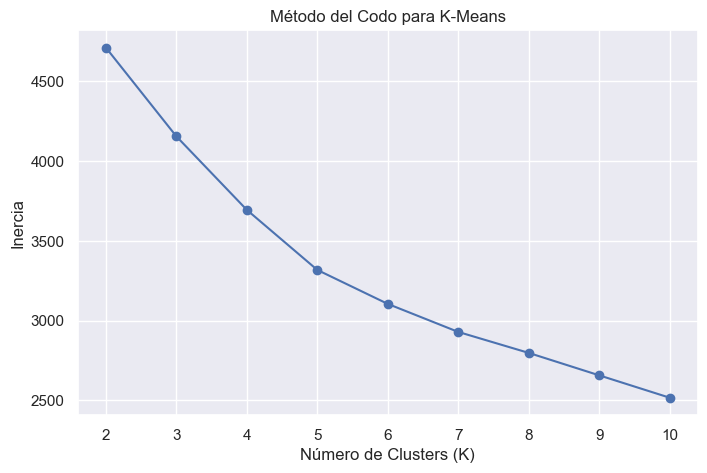

Observa el gráfico: elige el valor de K donde la línea 'forma un codo' (la disminución de la inercia se vuelve mucho más lenta).

>>> Aplicando K-Means con K=5 (¡Asegúrate de ajustar 'chosen_k' según el gráfico!) <<<

Etiquetas de cluster (0 a 4) añadidas al DataFrame (columna 'Cluster').

--- Análisis Descriptivo de los Clusters ---

Distribución de CVs por cluster:
Cluster
0     53
1    106
2    104
3    101
4    250
Name: count, dtype: int64

Medias de features por cluster:
Cluster                                  0            1            2  \
Porcentaje Lenguaje Técnico       5.357736     8.164811     6.983462   
texto_extraido_len            11478.264151  3181.235849  3902.221154   
Uso de negritas (estimado %)     19.152830    19.178302    21.737500   
Densidad Informacion (%)          5.203774     5.973491     5.652788   
Numero de Paginas                 7.547170     1.726415     2.326923   
secciones_completas               8.924528     6.858491     8.134615   
Website/Otro  

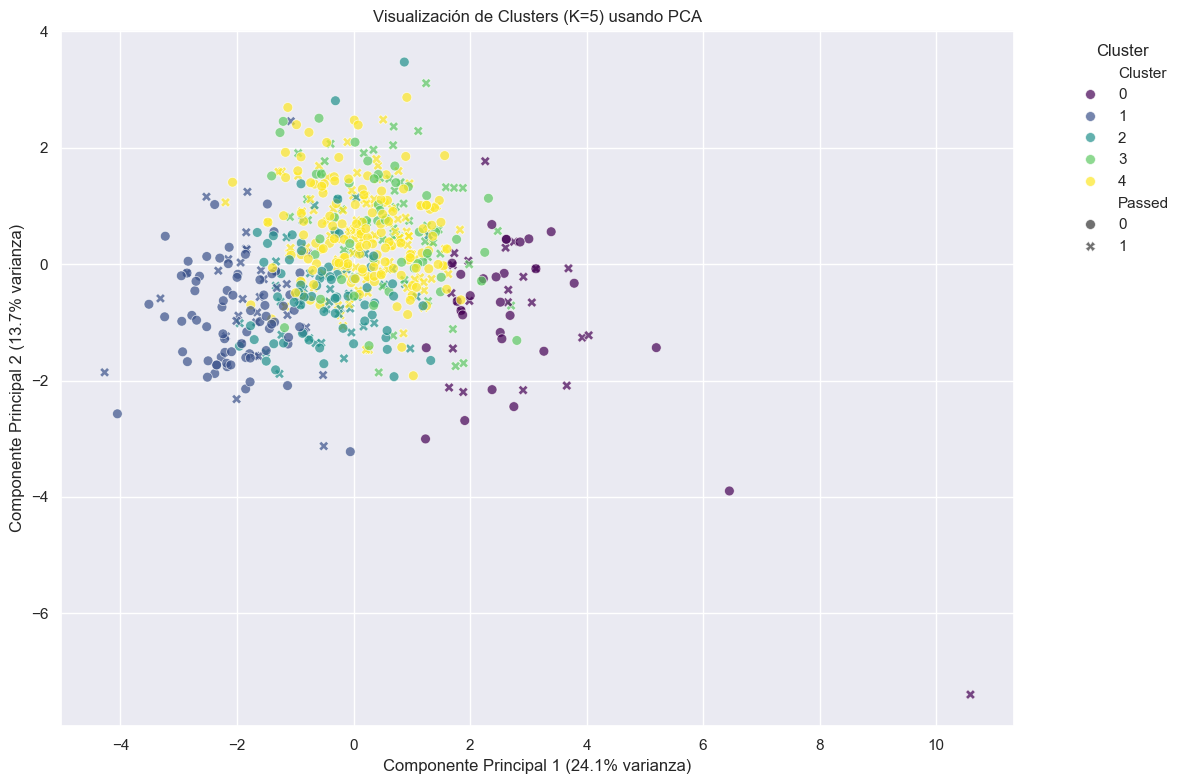

In [37]:
try:
    # Intentar detectar separador o especificarlo (ej. sep=',')
    df_cluster_orig = df9
    print(f"Datos cargados desde '{csv_path_cluster}'. Dimensiones: {df_cluster_orig.shape}")
    print("Columnas disponibles:", df_cluster_orig.columns.tolist())
except FileNotFoundError:
    print(f"Error: No se encontró el archivo '{csv_path_cluster}'.")
    df_cluster_orig = None
except Exception as e:
    print(f"Error cargando datos: {e}")
    df_cluster_orig = None

# --- Solo proceder si los datos se cargaron ---
if df_cluster_orig is not None:

    # --- 2. Preparar Datos para Clustering ---
    target_column = 'Passed'

    # Verificar si 'Passed' existe y separarla (la usaremos después)
    if target_column in df_cluster_orig.columns:
        y_labels = df_cluster_orig[target_column].copy()
        X_cluster = df_cluster_orig.drop(columns=[target_column])
        print(f"\nSeparando features (X) y target '{target_column}'.")
    else:
        print(f"\nAdvertencia: Columna '{target_column}' no encontrada. Se usarán todas las columnas para clustering.")
        y_labels = None
        X_cluster = df_cluster_orig.copy()

    # Asegurar que todas las features son numéricas
    original_cols = X_cluster.shape[1]
    X_cluster = X_cluster.select_dtypes(include=np.number)
    if X_cluster.shape[1] < original_cols:
         print(f"Advertencia: Se eliminaron {original_cols - X_cluster.shape[1]} columnas no numéricas.")

    # Verificar y manejar NaNs (Imputar si es necesario)
    if X_cluster.isnull().sum().sum() > 0:
        print(f"\nAdvertencia: {X_cluster.isnull().sum().sum()} NaNs encontrados. Imputando con la media...")
        from sklearn.impute import SimpleImputer
        imputer_cluster = SimpleImputer(strategy='mean')
        X_cluster_imputed = imputer_cluster.fit_transform(X_cluster)
        X_cluster = pd.DataFrame(X_cluster_imputed, columns=X_cluster.columns)
        print("Imputación completada.")
    else:
        print("\nNo se encontraron NaNs en las features.")

    # Guardar nombres de features
    feature_names_cluster = X_cluster.columns.tolist()
    print(f"Número de features para clustering: {len(feature_names_cluster)}")

    # --- 3. Escalar TODAS las Features ---
    print("\nEscalando todas las features para K-Means...")
    scaler_cluster = StandardScaler()
    X_scaled_cluster = scaler_cluster.fit_transform(X_cluster)
    print("Escalado completado.")

    # --- 4. Determinar Número Óptimo de Clusters (K) - Método del Codo ---
    print("\nCalculando inercia para K de 2 a 10 (Método del Codo)...")
    inertia = []
    k_range = range(2, 11) # Puedes ajustar este rango si quieres probar más clusters

    for k in k_range:
        kmeans_test = KMeans(n_clusters=k, random_state=42, n_init=10) # n_init='auto' en sklearn >= 1.3
        kmeans_test.fit(X_scaled_cluster)
        inertia.append(kmeans_test.inertia_) # Inertia: Suma de cuadrados intra-cluster

    # Graficar el codo
    try:
        plt.figure(figsize=(8, 5))
        plt.plot(k_range, inertia, marker='o')
        plt.xlabel('Número de Clusters (K)')
        plt.ylabel('Inercia')
        plt.title('Método del Codo para K-Means')
        plt.xticks(k_range)
        plt.grid(True)
        plt.show()
        print("Observa el gráfico: elige el valor de K donde la línea 'forma un codo' (la disminución de la inercia se vuelve mucho más lenta).")
    except Exception as e_elbow_plot:
         print(f"No se pudo generar el gráfico del codo: {e_elbow_plot}")

    # --- 5. Aplicar K-Means con K elegido ---
    # *** AJUSTA EL VALOR DE 'chosen_k' BASADO EN EL GRÁFICO DEL CODO ***
    chosen_k = 5  # Ejemplo: Elegir 4 clusters. ¡CAMBIA ESTO!
    print(f"\n>>> Aplicando K-Means con K={chosen_k} (¡Asegúrate de ajustar 'chosen_k' según el gráfico!) <<<")

    kmeans_final = KMeans(n_clusters=chosen_k, random_state=42, n_init=10)
    cluster_labels = kmeans_final.fit_predict(X_scaled_cluster)

    # Añadir etiquetas de cluster al DataFrame ORIGINAL (el que tiene 'Passed' si existía)
    df_clustered = df_cluster_orig.copy() # Usar el original cargado
    df_clustered['Cluster'] = cluster_labels
    print(f"\nEtiquetas de cluster (0 a {chosen_k-1}) añadidas al DataFrame (columna 'Cluster').")

    # --- 6. Análisis Básico de los Clusters ---
    print("\n--- Análisis Descriptivo de los Clusters ---")

    # Tamaño de cada cluster
    print("\nDistribución de CVs por cluster:")
    print(df_clustered['Cluster'].value_counts().sort_index())

    # Características promedio por cluster (usando las features seleccionadas antes del escalado)
    print("\nMedias de features por cluster:")
    # Usar 'feature_names_cluster' para asegurar que agrupamos por las columnas correctas
    try:
        cluster_analysis = df_clustered.groupby('Cluster')[feature_names_cluster].mean().transpose()
        pd.set_option('display.max_rows', None) # Mostrar todas las features
        print(cluster_analysis)
        pd.reset_option('display.max_rows')
        print("\n(Interpreta esto buscando diferencias grandes en las medias entre clusters)")
    except Exception as e_group:
        print(f"Error al calcular medias por cluster: {e_group}")


    # Relación con 'Passed' (si la columna existe)
    if y_labels is not None:
        print("\n--- Relación Exploratoria entre Clusters y 'Passed' ---")
        # Tabla de contingencia
        contingency_table = pd.crosstab(df_clustered['Cluster'], y_labels)
        print("\nTabla de Contingencia (Cluster vs Passed):")
        print(contingency_table)

        # Porcentaje de 'Passed' en cada cluster
        passed_perc_by_cluster = df_clustered.groupby('Cluster')['Passed'].mean() * 100
        print("\nPorcentaje de 'Passed'=1 en cada cluster (%):")
        print(passed_perc_by_cluster.round(2))

        # Prueba Chi-cuadrado
        try:
            chi2, p, dof, expected = chi2_contingency(contingency_table)
            print(f"\nPrueba Chi-cuadrado (Cluster vs Passed): p-value = {p:.4f}")
            if p < 0.05:
                print("--> Asociación significativa encontrada: La proporción de 'Passed' varía entre clusters.")
            else:
                print("--> No hay asociación significativa: La proporción de 'Passed' es similar entre clusters.")
        except ValueError:
            print("\nAdvertencia: No se pudo realizar Chi-cuadrado (posiblemente datos insuficientes).")
    else:
         print("\nColumna 'Passed' no disponible para análisis cruzado con clusters.")


    # --- 7. (Opcional) Visualización PCA ---
    print("\nGenerando visualización 2D de clusters usando PCA...")
    try:
        pca = PCA(n_components=2, random_state=42)
        # Usamos los datos escalados para PCA también
        X_pca = pca.fit_transform(X_scaled_cluster)
        print(f"Varianza explicada por los 2 componentes PCA: {pca.explained_variance_ratio_.sum():.2%}")

        # Crear DataFrame para graficar
        df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
        df_pca['Cluster'] = cluster_labels
        if y_labels is not None: # Añadir 'Passed' si existe para colorear diferente
             df_pca['Passed'] = y_labels

        plt.figure(figsize=(12, 8))
        sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='Cluster',
                        palette='viridis', s=50, alpha=0.7,
                        style='Passed' if y_labels is not None else None) # Diferente marcador si 'Passed' existe
        plt.title(f'Visualización de Clusters (K={chosen_k}) usando PCA')
        plt.xlabel(f'Componente Principal 1 ({pca.explained_variance_ratio_[0]:.1%} varianza)')
        plt.ylabel(f'Componente Principal 2 ({pca.explained_variance_ratio_[1]:.1%} varianza)')
        plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    except Exception as e_pca_plot:
        print(f"No se pudo generar gráfico PCA: {e_pca_plot}")

Aquí ya obtenemos una conclusión mucho más acertada sobre los clusters.
#### Clusters
1. Cluster 0: CVs muy largos (7.5 pág, 11478 chars) con pocas secciones completas (8.9). % Técnico bajo (5.4%). Uso de negritas promedio (19%). Sección Training Courses presente (98%). Uso de color (79%). Densidad baja.
Perfil Sugerido: "Largos y poco estructurados (orientados a training)".
2. Cluster 1: CVs muy cortos (1.7 pág, 3181 chars) y con menos secciones (6.9). % Técnico moderado (8.2%). Uso de negritas promedio (19%). Casi nunca tienen la sección Training Courses (flag=0.9%!). Densidad y uso de color promedios.
Perfil Sugerido: "Cortos y sin sección de Training".
3. Cluster 2: Longitud/páginas promedio (~2.3 pág, ~3900 chars). % Técnico promedio (7%). Uso de negritas ligeramente más alto (21.7%). NUNCA tienen Website/Otro (0%) y NUNCA usan color en texto (0%). Sección Training Courses presente (100%).
Perfil Sugerido: "Estándar, sin links personales ni color".
4. Cluster 3: Longitud/páginas moderada (~3 pág, ~5000 chars). % Técnico promedio (7.6%). Uso de negritas promedio (19.6%). SIEMPRE tienen Website/Otro (100%). Sección Training Courses presente (97%). Uso de color alto (81%).
Perfil Sugerido: "Con Website Personal".
5. Cluster 4: Longitud/páginas moderada (~2.5 pág, ~4600 chars). % Técnico promedio (7.7%). Uso de negritas promedio (20.5%). Nunca tienen Website/Otro (0%). Sección Training Courses presente (100%). SIEMPRE usan color en texto (100%). Es el grupo más grande.
Perfil Sugerido: "Estándar con color, sin website

#### Relación con la variable passed
1. Cluster 0 (Largos/Training): 45.3% Passed
2. Cluster 1 (Cortos/Sin Training): 32.1% Passed (La más baja)
3. Cluster 2 (Sin Website/Color): 39.4% Passed
4. Cluster 3 (Con Website, Training): 52.5% Passed (La más alta)
5. Cluster 4 (Estándar/Con Color): 44.0% Passed

*Escribir conclusiones*


#### 4 variables

In [39]:
selected_features4 = [
        'texto_extraido_len',       # Numérica
        'secciones_completas',      # Numérica
        'Website/Otro',             # Binaria (0/1)
        'Seccion_training_courses',  # Binaria (0/1) - El flag
        'Passed'
    ]

df4 = df_cluster_orig[selected_features4]

In [40]:
df4

,texto_extraido_len,secciones_completas,Website/Otro,Seccion_training_courses,Passed
0,3692,7,1,1,1
1,2703,8,1,1,1
2,2761,9,0,1,1
3,4732,7,0,1,1
4,4562,10,0,1,1
...,...,...,...,...,...
609,8464,9,1,1,0
610,25210,8,0,1,0
611,6154,10,0,1,0
612,1313,8,0,1,0


Datos cargados desde '../Bases/base_cvs/datos_para_modelar_cv.csv'. Dimensiones: (614, 5)
Columnas disponibles: ['texto_extraido_len', 'secciones_completas', 'Website/Otro', 'Seccion_training_courses', 'Passed']

Separando features (X) y target 'Passed'.

No se encontraron NaNs en las features.
Número de features para clustering: 4

Escalando todas las features para K-Means...
Escalado completado.

Calculando inercia para K de 2 a 10 (Método del Codo)...


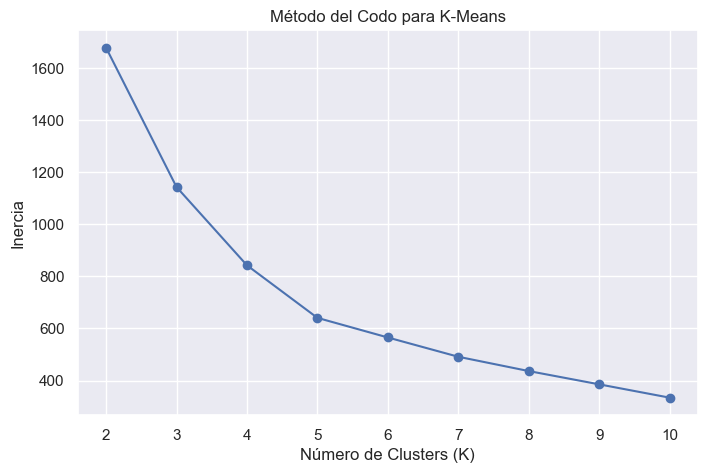

Observa el gráfico: elige el valor de K donde la línea 'forma un codo' (la disminución de la inercia se vuelve mucho más lenta).

>>> Aplicando K-Means con K=5 (¡Asegúrate de ajustar 'chosen_k' según el gráfico!) <<<

Etiquetas de cluster (0 a 4) añadidas al DataFrame (columna 'Cluster').

--- Análisis Descriptivo de los Clusters ---

Distribución de CVs por cluster:
Cluster
0    102
1    207
2    160
3    108
4     37
Name: count, dtype: int64

Medias de features por cluster:
Cluster                             0            1           2            3  \
texto_extraido_len        5185.813725  5253.483092  3441.20625  3261.620370   
secciones_completas          8.578431     9.246377     7.31875     6.925926   
Website/Otro                 1.000000     0.000000     0.00000     0.120370   
Seccion_training_courses     1.000000     1.000000     1.00000     0.000000   

Cluster                              4  
texto_extraido_len        13118.810811  
secciones_completas           8.864865  

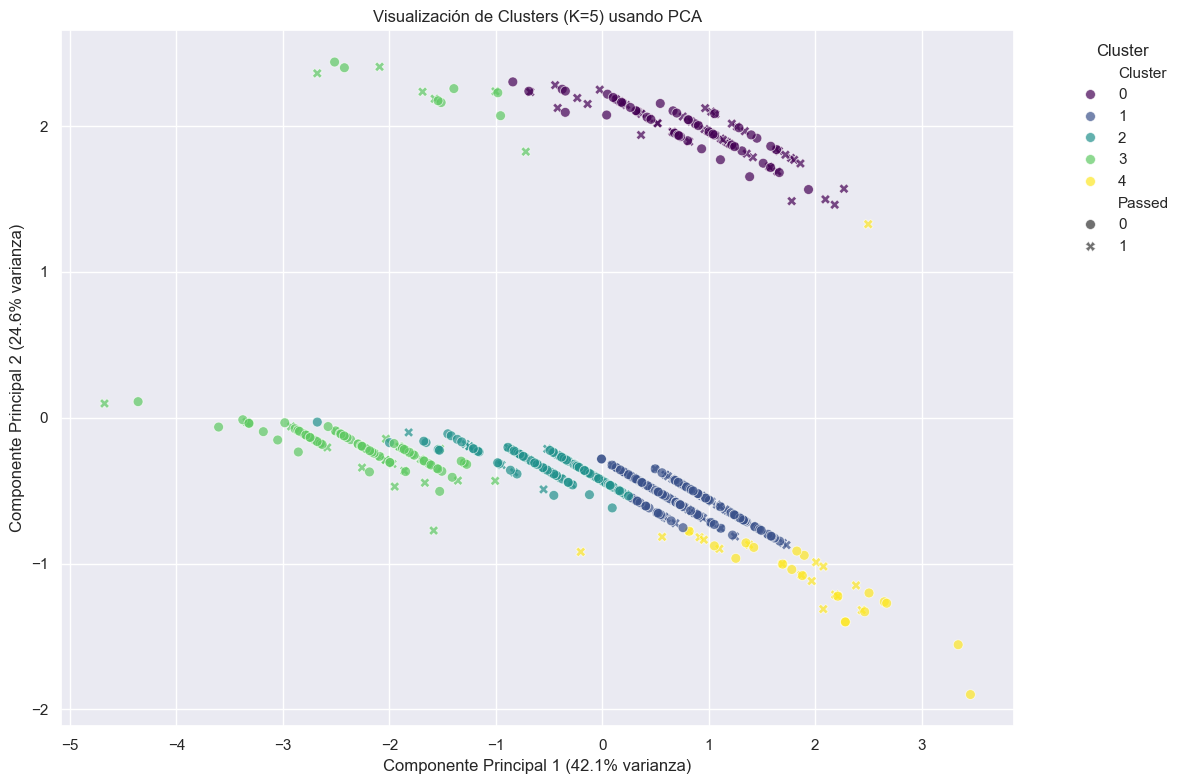

In [41]:
try:
    # Intentar detectar separador o especificarlo (ej. sep=',')
    df_cluster_orig = df4
    print(f"Datos cargados desde '{csv_path_cluster}'. Dimensiones: {df_cluster_orig.shape}")
    print("Columnas disponibles:", df_cluster_orig.columns.tolist())
except FileNotFoundError:
    print(f"Error: No se encontró el archivo '{csv_path_cluster}'.")
    df_cluster_orig = None
except Exception as e:
    print(f"Error cargando datos: {e}")
    df_cluster_orig = None

# --- Solo proceder si los datos se cargaron ---
if df_cluster_orig is not None:

    # --- 2. Preparar Datos para Clustering ---
    target_column = 'Passed'

    # Verificar si 'Passed' existe y separarla (la usaremos después)
    if target_column in df_cluster_orig.columns:
        y_labels = df_cluster_orig[target_column].copy()
        X_cluster = df_cluster_orig.drop(columns=[target_column])
        print(f"\nSeparando features (X) y target '{target_column}'.")
    else:
        print(f"\nAdvertencia: Columna '{target_column}' no encontrada. Se usarán todas las columnas para clustering.")
        y_labels = None
        X_cluster = df_cluster_orig.copy()

    # Asegurar que todas las features son numéricas
    original_cols = X_cluster.shape[1]
    X_cluster = X_cluster.select_dtypes(include=np.number)
    if X_cluster.shape[1] < original_cols:
         print(f"Advertencia: Se eliminaron {original_cols - X_cluster.shape[1]} columnas no numéricas.")

    # Verificar y manejar NaNs (Imputar si es necesario)
    if X_cluster.isnull().sum().sum() > 0:
        print(f"\nAdvertencia: {X_cluster.isnull().sum().sum()} NaNs encontrados. Imputando con la media...")
        from sklearn.impute import SimpleImputer
        imputer_cluster = SimpleImputer(strategy='mean')
        X_cluster_imputed = imputer_cluster.fit_transform(X_cluster)
        X_cluster = pd.DataFrame(X_cluster_imputed, columns=X_cluster.columns)
        print("Imputación completada.")
    else:
        print("\nNo se encontraron NaNs en las features.")

    # Guardar nombres de features
    feature_names_cluster = X_cluster.columns.tolist()
    print(f"Número de features para clustering: {len(feature_names_cluster)}")

    # --- 3. Escalar TODAS las Features ---
    print("\nEscalando todas las features para K-Means...")
    scaler_cluster = StandardScaler()
    X_scaled_cluster = scaler_cluster.fit_transform(X_cluster)
    print("Escalado completado.")

    # --- 4. Determinar Número Óptimo de Clusters (K) - Método del Codo ---
    print("\nCalculando inercia para K de 2 a 10 (Método del Codo)...")
    inertia = []
    k_range = range(2, 11) # Puedes ajustar este rango si quieres probar más clusters

    for k in k_range:
        kmeans_test = KMeans(n_clusters=k, random_state=42, n_init=10) # n_init='auto' en sklearn >= 1.3
        kmeans_test.fit(X_scaled_cluster)
        inertia.append(kmeans_test.inertia_) # Inertia: Suma de cuadrados intra-cluster

    # Graficar el codo
    try:
        plt.figure(figsize=(8, 5))
        plt.plot(k_range, inertia, marker='o')
        plt.xlabel('Número de Clusters (K)')
        plt.ylabel('Inercia')
        plt.title('Método del Codo para K-Means')
        plt.xticks(k_range)
        plt.grid(True)
        plt.show()
        print("Observa el gráfico: elige el valor de K donde la línea 'forma un codo' (la disminución de la inercia se vuelve mucho más lenta).")
    except Exception as e_elbow_plot:
         print(f"No se pudo generar el gráfico del codo: {e_elbow_plot}")

    # --- 5. Aplicar K-Means con K elegido ---
    # *** AJUSTA EL VALOR DE 'chosen_k' BASADO EN EL GRÁFICO DEL CODO ***
    chosen_k = 5  # Ejemplo: Elegir 4 clusters. ¡CAMBIA ESTO!
    print(f"\n>>> Aplicando K-Means con K={chosen_k} (¡Asegúrate de ajustar 'chosen_k' según el gráfico!) <<<")

    kmeans_final = KMeans(n_clusters=chosen_k, random_state=42, n_init=10)
    cluster_labels = kmeans_final.fit_predict(X_scaled_cluster)

    # Añadir etiquetas de cluster al DataFrame ORIGINAL (el que tiene 'Passed' si existía)
    df_clustered = df_cluster_orig.copy() # Usar el original cargado
    df_clustered['Cluster'] = cluster_labels
    print(f"\nEtiquetas de cluster (0 a {chosen_k-1}) añadidas al DataFrame (columna 'Cluster').")

    # --- 6. Análisis Básico de los Clusters ---
    print("\n--- Análisis Descriptivo de los Clusters ---")

    # Tamaño de cada cluster
    print("\nDistribución de CVs por cluster:")
    print(df_clustered['Cluster'].value_counts().sort_index())

    # Características promedio por cluster (usando las features seleccionadas antes del escalado)
    print("\nMedias de features por cluster:")
    # Usar 'feature_names_cluster' para asegurar que agrupamos por las columnas correctas
    try:
        cluster_analysis = df_clustered.groupby('Cluster')[feature_names_cluster].mean().transpose()
        pd.set_option('display.max_rows', None) # Mostrar todas las features
        print(cluster_analysis)
        pd.reset_option('display.max_rows')
        print("\n(Interpreta esto buscando diferencias grandes en las medias entre clusters)")
    except Exception as e_group:
        print(f"Error al calcular medias por cluster: {e_group}")


    # Relación con 'Passed' (si la columna existe)
    if y_labels is not None:
        print("\n--- Relación Exploratoria entre Clusters y 'Passed' ---")
        # Tabla de contingencia
        contingency_table = pd.crosstab(df_clustered['Cluster'], y_labels)
        print("\nTabla de Contingencia (Cluster vs Passed):")
        print(contingency_table)

        # Porcentaje de 'Passed' en cada cluster
        passed_perc_by_cluster = df_clustered.groupby('Cluster')['Passed'].mean() * 100
        print("\nPorcentaje de 'Passed'=1 en cada cluster (%):")
        print(passed_perc_by_cluster.round(2))

        # Prueba Chi-cuadrado
        try:
            chi2, p, dof, expected = chi2_contingency(contingency_table)
            print(f"\nPrueba Chi-cuadrado (Cluster vs Passed): p-value = {p:.4f}")
            if p < 0.05:
                print("--> Asociación significativa encontrada: La proporción de 'Passed' varía entre clusters.")
            else:
                print("--> No hay asociación significativa: La proporción de 'Passed' es similar entre clusters.")
        except ValueError:
            print("\nAdvertencia: No se pudo realizar Chi-cuadrado (posiblemente datos insuficientes).")
    else:
         print("\nColumna 'Passed' no disponible para análisis cruzado con clusters.")


    # --- 7. (Opcional) Visualización PCA ---
    print("\nGenerando visualización 2D de clusters usando PCA...")
    try:
        pca = PCA(n_components=2, random_state=42)
        # Usamos los datos escalados para PCA también
        X_pca = pca.fit_transform(X_scaled_cluster)
        print(f"Varianza explicada por los 2 componentes PCA: {pca.explained_variance_ratio_.sum():.2%}")

        # Crear DataFrame para graficar
        df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
        df_pca['Cluster'] = cluster_labels
        if y_labels is not None: # Añadir 'Passed' si existe para colorear diferente
             df_pca['Passed'] = y_labels

        plt.figure(figsize=(12, 8))
        sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='Cluster',
                        palette='viridis', s=50, alpha=0.7,
                        style='Passed' if y_labels is not None else None) # Diferente marcador si 'Passed' existe
        plt.title(f'Visualización de Clusters (K={chosen_k}) usando PCA')
        plt.xlabel(f'Componente Principal 1 ({pca.explained_variance_ratio_[0]:.1%} varianza)')
        plt.ylabel(f'Componente Principal 2 ({pca.explained_variance_ratio_[1]:.1%} varianza)')
        plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    except Exception as e_pca_plot:
        print(f"No se pudo generar gráfico PCA: {e_pca_plot}")

Finalmente, entendemos que las 4 variables seleccionadas, así mismo explican la pertenencia a cierto tipo de cluster y la posibilidad de pertenecer a un grupo que pasa (o no) el filtro de nuestros clientes.

#### Clusters
1. Cluster 0: Longitud y secciones promedio. Siempre tienen Website/Otro (1.0) y siempre tienen Sección Training Courses (1.0).
Perfil Sugerido: "Con Website y Sección Training".
2. Cluster 1: Longitud y secciones promedio. Nunca tienen Website/Otro (0.0) y siempre tienen Sección Training Courses (1.0). (El grupo más grande).
Perfil Sugerido: "Sin Website, con Sección Training (Grupo Mayoritario)".
3. Cluster 2: CVs más cortos (3441 chars) y con menos secciones (7.3). Nunca tienen Website/Otro (0.0) y siempre tienen Sección Training Courses (1.0).
Perfil Sugerido: "Cortos, sin Website, con Sección Training".
4. Cluster 3: CVs más cortos (3261 chars) y con menos secciones (6.9). Presencia variable de Website/Otro (12%). NUNCA tienen Sección Training Courses (0.0).
Perfil Sugerido: "Cortos y SIN Sección Training".
5. Cluster 4: CVs MUY largos (13119 chars) y con número promedio de secciones (8.9). Presencia baja de Website/Otro (3%). Casi siempre tienen Sección Training Courses (97%).
Perfil Sugerido: "Muy Largos".

#### Relación con la variable passed
1. Cluster 0 (Con Website y Training): 53.9% Passed (La más alta)
2. Cluster 1 (Sin Website, con Training, Medio): 44.0% Passed
3. Cluster 2 (Corto, Sin Website, con Training): 39.4% Passed
4. Cluster 3 (Corto, SIN Training): 32.4% Passed (La más baja)
5. Cluster 4 (Muy Largo, con training): 48.6% Passed

*Escribir conclusiones*